# CPPGA3254 - Econometrics I
PPGECO — 2nd Semester, 2025 <br>
University of Brasília (UnB) <br>
Prof. Dr. Daniel Cajueiro <br>
Student: Matheus Fiuza de Alencastro — 251100926 <br>

This code is provided to satisfy the requirements of the assigned exercise "Exercício Empírico do Curso de Econometria I (2025)" and constitutes an attempt to replicate the analysis by D. Mark Anderson, Yang Liang, and Joseph J. Sabia on mandatory seatbelt laws and traffic fatalities, published in the Journal of Applied Econometrics.

> Anderson, D. M., Liang, Y., & Sabia, J. J. (2024). Mandatory seatbelt laws and traffic fatalities: A reassessment. Journal of Applied Econometrics, 39(3), 513–521. https://doi.org/10.1002/jae.3026

All data and replication code are available from the authors at: https://journaldata.zbw.eu/dataset/b5f4c0f6-dd9e-4cdc-bea4-04a7efdb50dd/resource/98aa0a14-b449-46b4-8cac-23a1ef0094fd


## Intro

The referenced article is a reassessment of Cohen and Einav (2003), which found that mandatory seatbelt laws were associated with a 4–6% reduction in traffic fatalities among motor vehicle occupants. In this reassessment, the authors replicate the estimates of the original study—which applied a two-way fixed effects (TWFE) model—while expanding the time window of analysis. Additionally, they employ event-study models and alternative methods to address potential biases inherent in TWFE. Their results are consistent with the findings of Cohen and Einav (2003) yet some reconsiderations are proposed.

The main objective of this exercise is to replicate the TWFE estimator robust to heterogeneous treatment effects, as proposed by Sun and Abraham (2021) and explored by Anderson et al. (2024). As noted, the original authors used Stata to obtain their results; therefore, the primary contribution of this exercise is the translation and implementation of their analysis in Python. All information regarding package versions and dependencies is available in the pyproject.toml file.

## Replication Code

In [1]:
# Package Imports

import pandas as pd
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt

# Data Loading

data = pd.read_csv('data/master_1983to2019.csv')


### Cohorts and Treatment Identification

For the TWFE specification robust to time heterogeneity, we construct one parameter for each interaction between cohorts and relative time. In order to create the cohorts, we cluster the states which passed Primary Seatbelt Laws in the same year. In addition, for this estimation we only consider as treated those States that passed primary laws first. The control group are those states that never passed primary laws (PSLs). Switchers (i.e those states that first approved secondary seatbelt laws and moved to primary laws are discarted from our sample). This specification follows Anderson et al. (2024).

In [2]:
# Cohorts and Treatment Identification

# Identify first year of primary law
psl_years = data[data['primary'] == 1].groupby('fips')['year'].min().reset_index() # fips is the state code
psl_years.rename(columns={'year':'cohort_year'}, inplace=True)
data = data.merge(psl_years, on='fips', how='left')

# Identify first year of secondary law
ssl_years = data[data['secondary'] == 1].groupby('fips')['year'].min().reset_index()
ssl_years.rename(columns={'year':'ssl_start'}, inplace=True)
data = data.merge(ssl_years, on='fips', how='left')

# Define treated
data['is_treated'] = np.where(
    (data['cohort_year'].notna()) & (data['ssl_start'].isna()), 1, 0
) # PSL and NO SSL

# Define control
data['is_control'] = np.where(
    (data['cohort_year'].isna()), 1, 0
)

# Filter out Switchers
df_reg = data[(data['is_treated'] == 1) | (data['is_control'] == 1)].copy()


### Time Identification

For the model we must define the time as relative to the treatment. Also, following the article`s specification, the relative time dummy is set to 1 if t is 4 or more years prior to treatment. The same is valid for 4 or more years after treatment.

In [3]:
df_reg['rel_year'] = df_reg['year'] - df_reg['cohort_year']
df_reg['rel_year_binned'] = df_reg['rel_year'].clip(lower=-4, upper=4)

### Variables and Formula

The robust to heterogeneous time effects model commands the creation of the Cohort-RelativeYear interaction dummies. Note that the reference period is skipped to avoid perfect multicollinearity.

In [4]:
interaction_vars = []

cohorts = df_reg[df_reg['is_treated']==1]['cohort_year'].unique()
cohorts.sort()

for cohort in cohorts:
    for rel_t in range(-4, 5): # Range -4 to +4
        if rel_t == -1: continue # Skip reference period (t = -1)
        
        col_name = f'att_C{int(cohort)}_T{rel_t}'.replace("-", "m")
        
        # Create Dummy: 1 if unit is in this cohort AND relative time matches
        df_reg[col_name] = np.where(
            (df_reg['cohort_year'] == cohort) & (df_reg['rel_year_binned'] == rel_t), 
            1, 0
        )
        interaction_vars.append(col_name)

control_vars = [
    'secondary', 'ln_pctblack', 'ln_pcthisp', 'ln_medinc', 'ln_age', 
    'ln_gastax', 'ln_violentcrimerate', 'ln_propcrimerate', 
    'ln_unemprate', 'ln_ruralvmt', 'ln_urbanvmt', 'speed65',
    'speed70', 'mlda21', 'bac8', 'ln_ruralden', 'ln_urbanden'
]

formula = f"adj_occrate ~ {' + '.join(interaction_vars)} + {' + '.join(control_vars)} + C(fips) + C(year)"

### Regression

Standard errors are clustered also following Anderson et al. (2024)

In [5]:
model = smf.ols(formula, data=df_reg).fit(
    cov_type='cluster',
    cov_kwds={'groups': df_reg['fips']}
)

### ATT Estimation

For the ATT Estimation we consider the estimated parameters by OLS for each post treatment period and calculate the weighted average using the number of treated units in the cohort. Finally the "total" ATT estimator is given by summing all the post treatment ATTs and dividing them by number of the post treatment periods.

In [6]:
# ATT Estimation

results = []
relative_years = range(-4, 5)
total_treated_units = df_reg[df_reg['is_treated'] == 1]['fips'].nunique()

for t in relative_years:

    if t == -1:

        results.append({
            'rel_time': -1,
            'att':0,
            'ci_lower':0,
            'ci_upper':0,
            'se':0,
            't_stat':0,
            'p_value':1.0,
            'type': 'Dynamic'
        })

        continue

    weights = {name: 0.0 for name in model.params.index}

    coef_names = [v for v in interaction_vars if v.endswith(f'_T{t}'.replace("-", "m"))]

    for c_name in coef_names:
        c_year = int(c_name.split('_')[1].replace('C', ''))

        cohort_weight = df_reg[df_reg['cohort_year'] == c_year]['fips'].nunique()

        weights[c_name] = cohort_weight/total_treated_units

    r_matrix = pd.Series(weights)
    test = model.t_test(r_matrix)

    att= test.effect[0]
    ci = test.conf_int(alpha=0.05)

    if hasattr(test.sd, 'ndim') and test.sd.ndim > 1:
        se = test.sd[0][0]
    else:
        se = test.sd[0]

    p_val = test.pvalue.item() if hasattr(test.pvalue, 'item') else test.pvalue

    results.append({
        'rel_time': t,
        'att': att,
        'ci_lower': ci[0][0],
        'ci_upper': ci[0][1],
        'se': se,
        't_stat': test.tvalue.item() if hasattr(test.tvalue, 'item') else test.tvalue,
        'p_value': p_val,
        'type': 'Dynamic'
    })



df_plot = pd.DataFrame(results)



In [7]:
# Total ATT Calculation (we divide by number of post treatment periods)

post_periods = [0, 1, 2, 3, 4]
num_periods = len(post_periods)

total_weights = {name: 0.0 for name in model.params.index}

for t in post_periods:
    coef_names = [v for v in interaction_vars if v.endswith(f'_T{t}'.replace("-", "m"))]

    for c_name in coef_names:
        c_year = int(c_name.split('_')[1].replace('C', ''))

        cohort_weight = df_reg[df_reg['cohort_year'] == c_year]['fips'].nunique()

        total_weights[c_name] = (cohort_weight / total_treated_units) / num_periods


total_test = model.t_test(pd.Series(total_weights))

t_att = total_test.effect[0]
t_ci = total_test.conf_int(alpha=0.05)
t_p_val = total_test.pvalue.item() if hasattr(total_test.pvalue, 'item') else total_test.pvalue
t_se = total_test.sd[0][0] if hasattr(total_test.sd, 'ndim') and total_test.sd.ndim > 1 else total_test.sd[0]

results.append({
    'rel_time': 'Total',
    'att': t_att,
    'ci_lower': t_ci[0][0],
    'ci_upper': t_ci[0][1],
    'se': t_se,
    't_stat': total_test.tvalue.item() if hasattr(total_test.tvalue, 'item') else total_test.tvalue,
    'p_value': t_p_val,
    'type':'Total ATT'

})

results_df = pd.DataFrame(results)


### Estimates Plot and Results

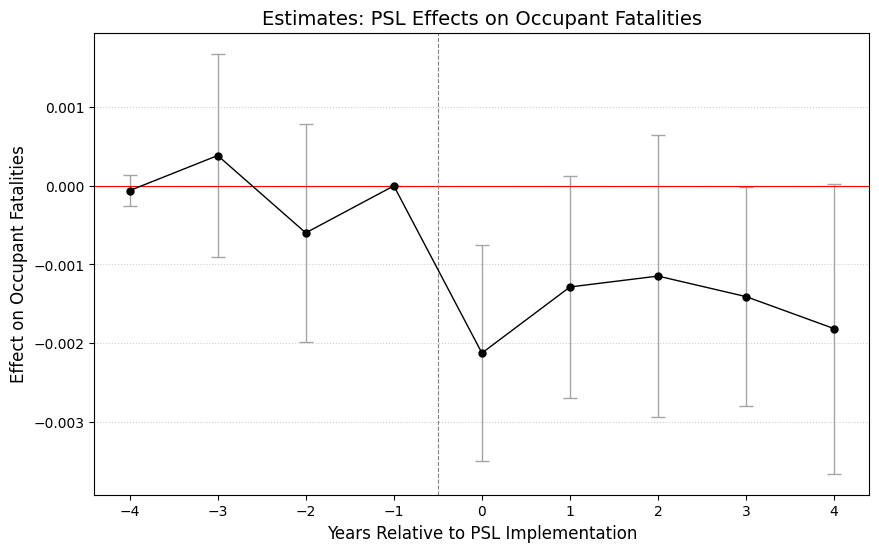

In [8]:
plt.figure(figsize=(10, 6))

plt.errorbar(
    x=df_plot['rel_time'], 
    y=df_plot['att'], 
    yerr=[df_plot['att'] - df_plot['ci_lower'], df_plot['ci_upper'] - df_plot['att']],
    fmt='-o',
    color = 'black',
    ecolor="#A5A5A5",
    capsize=5,
    markersize=5,
    linewidth=1,
    label='Interaction-Weighted Estimate'
)

plt.axhline(0, color='red', linestyle='-', linewidth=0.8) # Zero line
plt.axvline(-0.5, color='gray', linestyle='--', linewidth=0.8) # Treatment line

plt.xlabel('Years Relative to PSL Implementation', fontsize=12)
plt.ylabel('Effect on Occupant Fatalities', fontsize=12)
plt.title('Estimates: PSL Effects on Occupant Fatalities', fontsize=14)
plt.grid(axis='y', linestyle=':', alpha=0.6)

plt.xticks(range(-4, 5))

plt.show()

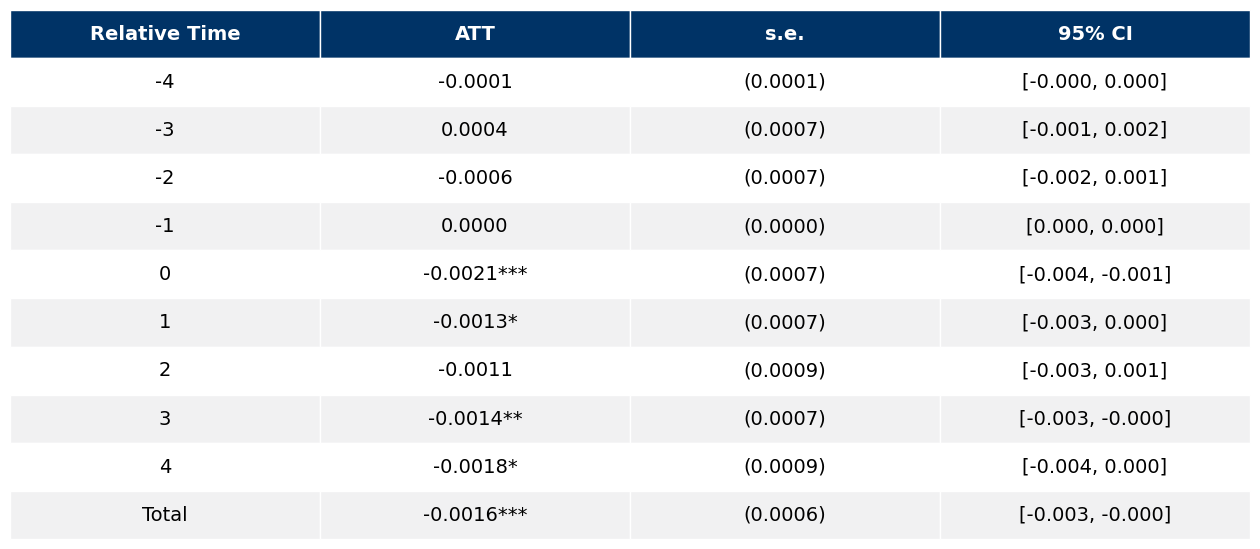

In [9]:
# Exporting Results Table

def format_significance(row):
    if row['p_value'] < 0.01:
        stars = '***'
    elif row['p_value'] < 0.05:
        stars = '**'
    elif row['p_value'] < 0.1:
        stars = '*'
    else:
        stars = ''
    
    return f"{row['att']:.4f}{stars}"

df_display = results_df.copy()

df_display['Relative Time'] = df_display['rel_time']
df_display['ATT'] = df_display.apply(format_significance, axis=1)
df_display['s.e.'] = df_display['se'].apply(lambda x: f"({x:.4f})")
df_display['95% CI'] = df_display.apply(lambda x: f"[{x['ci_lower']:.3f}, {x['ci_upper']:.3f}]", axis=1)

cols_to_keep = ['Relative Time', 'ATT', 's.e.', '95% CI']

df_final = df_display[cols_to_keep]

def render_mpl_table(data, col_width=2.0, row_height=0.625, font_size=14,
                     header_color='#003366', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, cellLoc='center', **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in mpl_table._cells.items():
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax

ax = render_mpl_table(df_final, header_columns=0, col_width=4.0)

plt.show()

In [10]:
# Effect on the dependent variable
pre_psl_mean = df_reg[(df_reg['is_treated'] == 1) & (df_reg['year'] < df_reg['cohort_year'])]['adj_occrate'].mean()

att_coefficient = results_df[results_df['type'] == 'Total ATT']['att'].values[0]

variation = (att_coefficient / pre_psl_mean) * 100

print(f"Pre-Treatment Mean: {pre_psl_mean:.4f}")
print(f"Variation: {variation:.2f}%")

Pre-Treatment Mean: 0.0222
Variation: -7.01%


## Final Thoughts

This exercise successfully replicated the TWFE robust to time heterogeneity displayed on table 1 column 7 of Anderson, Liang, and Sabia (2024), applying the interaction-weighted estimator proposed by Sun and Abraham (2021) to reassess the impact of Primary Seatbelt Laws (PSLs) on traffic fatalities.

## References

Anderson, D. M., Liang, Y., & Sabia, J. J. (2024). Mandatory seatbelt laws and traffic fatalities: A reassessment. Journal of Applied Econometrics, 39(3), 513–521. https://doi.org/10.1002/jae.3026

Cohen, A., & Einav, L. (2003). The effects of mandatory seat belt laws on driving behavior and traffic fatalities. Review of Economics and Statistics, 85(4), 828–843. https://doi.org/10.1162/003465303772815754

Goodman-Bacon, A. (2021). Difference-in-differences with variation in treatment timing. Journal of Econometrics, 225(2), 254~277. https://doi.org/10.1016/j.jeconom.2021.03.014.

Matheus Facure, "The Diff-in-Diff Saga," in Causal Inference for the Brave and True, accessed [Dec. 2025], https://matheusfacure.github.io/python-causality-handbook/24-The-Diff-in-Diff-Saga.html.

Sun, L., & Abraham, S. (2021). Estimating dynamic treatment effects in event studies with heterogeneous treatment effects. Journal of Econometrics, 225(2), 175–199. https://doi.org/10.1016/j.jeconom.2020.09.006


